In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.special as ss
import scipy.stats as stats

In [2]:
# create coherence for 10 averages
N = 100
data1 = np.random.randn(16384 * N)
data2 = np.random.randn(16384 * N)
#comb =  np.zeros(data1.shape)
srate = 16384
First=1
for ii in range(N):
    data1fft = np.fft.rfft(data1[srate*ii:srate*(ii+1)])
    data2fft = np.fft.rfft(data2[srate*ii:srate*(ii+1)])
    if First:
        csd = np.conj(data1fft) * data2fft
        psd1 = np.conj(data1fft) * data1fft
        psd2 = np.conj(data2fft) * data2fft
        First = 0
    else:
        csd = (csd * ii + np.conj(data1fft) * data2fft) / (ii + 1)
        psd1 = (psd1 * ii + np.conj(data1fft) * data1fft) / (ii + 1)
        psd2 = (psd2 * ii + np.conj(data2fft) * data2fft) / (ii + 1)

freqs = np.fft.rfftfreq(16384, d=1./16384)
coh = np.abs(csd)**2 / (psd1 * psd2)
#print len(coh)
#coh[::8] = 3 * 1./N

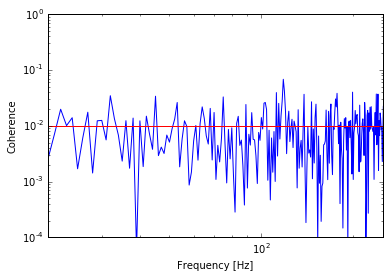

In [3]:
# plot coherence ones just to check it has expected behavior
plot = plt.figure()
plt.plot(freqs, np.abs(coh))
plt.plot([freqs[0], freqs[-1]], [1./N, 1./N],'r')
ax = plt.gca()
ax.set_ylabel('Coherence')
ax.set_xlabel('Frequency [Hz]')
ax.set_yscale('log')
ax.set_ylim(1e-4, 1)
ax.set_xscale('log')
ax.set_xlim(20,250)
plt.show()

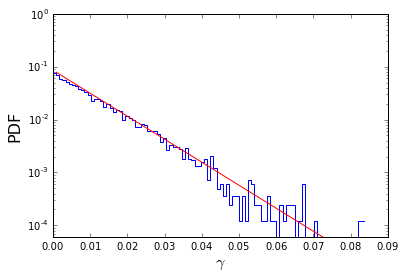

In [4]:
# plot histogram of coherence and make sure it acts as expected (exponential distribution)
coh = np.abs(coh)
vals, binedges = np.histogram(coh, bins=100)
vals = vals / np.float(np.sum(vals))
# this normalization with alpha doesn't work...
alpha = N / (1 - np.exp(-N))
plot = plt.figure()
plt.step(binedges[:-1], vals)
plt.plot(binedges[1:], np.max(vals) * np.exp(-N * binedges[1:]),'r')
ax = plt.gca()
ax.set_yscale("log")
ax.set_xlabel('$\gamma$',fontsize=16)
ax.set_ylabel('PDF',fontsize=16)
ax.set_ylim(5e-1 * 1./len(freqs), 1)
plt.show()

In [5]:
def getdist(b, n, N, diff=0, extranorm=1):
    """
    b = bins (summed coherence vals)
    n = number of sums
    N = number of averages for coherences
    """
    logdist = n * np.log(N) + (n-1) * np.log(b-diff) - N*(b-diff) - ss.gammaln(n) - ss.gammainc(n,n*N)
    dist = extranorm * np.exp(logdist)
    return dist

def getsums(n,k):
    sums = []
    for jj in range(k):
        idxs = np.random.randint(low=0, high=8193, size=n)
        sums.append(np.sum(coh[idxs]))
    return sums

def gethist(n,k):
    sums = getsums(n,k)
    [v, b] = np.histogram(sums, bins=100)
    v = v / np.float(np.sum(v))
    return v, b[:-1]

In [ ]:
diffs = []
extranorms = []
ns = []
for n in np.arange(1,10000,1000):
    v, b = gethist(n, 10000)
    bw = b[1] - b[0]
    dist = getdist(b, n, N)
    extranorm = np.max(v) / bw / np.max(dist)
    diff = np.mean(b[v==np.max(v)] - b[dist==np.max(dist)])
    dist2 = getdist(b, n, N, diff=diff, extranorm=extranorm)
    diffs.append(diff)
    extranorms.append(extranorm)
    ns.append(n)

d = np.polyfit(ns,diffs,1)
print 'diffs go as %4.4f * n + %4.4f' % (d[0], d[1])
print ns
theor = d[0] * np.asarray(ns) + d[1]
print theor
fig = plt.figure()
plt.plot(ns, diffs)
ax = plt.gca()
ax.plot(ns, extranorms)
ax.plot(ns, theor)
plt.show()


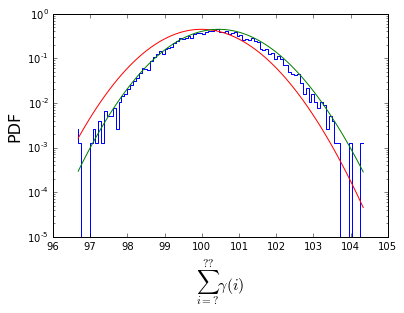

3.02904490289
0.464322989004


In [7]:
n = 10000
k = 10000
vals2, b = gethist(n,k)
bw = b[1] - b[0]
dist = getdist(b, n, N)
extranorm = np.max(vals2) / bw / np.max(dist)
diff = np.mean(b[vals2==np.max(vals2)] - b[dist==np.max(dist)])
dist2 = getdist(b, n, N, diff=diff, extranorm=extranorm)
plot = plt.figure()
plt.step(b, vals2/bw)
plt.plot(b,dist*extranorm,'r')
plt.plot(b,dist2,'g')
ax = plt.gca()
ax.set_yscale("log")
ax.set_xlabel('$\sum_{i=?}^{??}\gamma(i)$',fontsize=16)
ax.set_ylabel('PDF',fontsize=16)
#ax.set_ylim(5e-1 * 1./len(freqs), 1)
plt.show()
print extranorm
print diff